<a href="https://colab.research.google.com/github/elijaydot/AISaturdayLagos/blob/main/notebooks/C9TeamSeedGuard_ModelTrainingVisuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re

# Load the data from the GitHub URL
github_url = 'https://raw.githubusercontent.com/AISaturdaysLagos/C9-team-seedguard/main/data/combined_labeled_batch.csv'

# Load the data
try:
    df = pd.read_csv(github_url, engine='python', on_bad_lines='warn')
except Exception as e:
    print(f"Error loading CSV: {e}")
    # Optionally, try with a different on_bad_lines setting if 'warn' doesn't work well
    try:
        df = pd.read_csv(github_url, engine='python', on_bad_lines='skip')
        print("Successfully loaded CSV by skipping bad lines.")
    except Exception as e2:
        print(f"Error loading CSV even after skipping bad lines: {e2}")
        df = None # Ensure df is None if loading fails


# Define a function to remove specified words
def remove_words(text):
    if isinstance(text, str):
        # Use regex to remove 'title', 'Topic' followed by any character (non-greedy), and 'selftext'
        text = re.sub(r'title|Topic.*?|selftext', '', text, flags=re.IGNORECASE)
    return text

# Apply the function to the relevant columns (assuming text data is in 'combined_text' or similar)
# Replace 'combined_text' with the actual column name containing the text data if it's different.
if df is not None:
    if 'combined_text' in df.columns:
        df['combined_text'] = df['combined_text'].apply(remove_words)
    elif 'text' in df.columns: # Assuming 'text' might also contain the relevant information
        df['text'] = df['text'].apply(remove_words)
    else:
        print("Could not find a suitable text column to remove words from. Please check your dataframe.")

    # Display the first few rows of the modified DataFrame
    display(df.head())

combined_text  source  \
0  : Not the usual suspects: Novel genetic basis ...  Reddit   
1  : Biotech potato varieties offer complete resi...  Reddit   
2  : A biotech shield for cowpea against the majo...  Reddit   
3  : Pro-GMO Ethos Chocolate brand launches to de...  Reddit   
4  : India cancels royalties seed companies pay B...  Reddit   

                                       Core Argument  \
0  Biotech crops exhibit a novel genetic basis fo...   
1  Biotech potato varieties provide complete resi...   
2  Biotech provides a shield for cowpea against m...   
3  Pro-GMO chocolate brand launches to demystify ...   
4  India's cancellation of royalties for GMO cott...   

                              Emotional Undercurrent  \
0                        Neutral - factual statement   
1                 Positive - enthusiasm for benefits   
2                         Positive - protective tone   
3  Positive - enthusiasm and support for pro-GMO ...   
4           Negative - concern over economic impacts   

  Speaker Perspective/Stakeholder Sentiment  
0            Scientist/Researcher   Neutral  
1         Industry Representative  Positive  
2         Industry Representative  Positive  
3                        Consumer  Positive  
4         Industry Representative  Negative

# Task

Examine the top words for each topic to understand the main themes and concepts discussed in the text data.
Visualize the topic model results to explore the relationships between topics and documents.
Reasoning: I need to visualize the LDA model results to explore the relationships between topics and documents as per the subtask instructions.
This involves using the pyLDAvis library with the fitted LDA model, the document-term matrix, and the CountVectorizer.


In [ ]:
!pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 6.7 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import re # Import re

# Download necessary NLTK data (if you haven't already)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower() # Convert to lowercase
        text = re.sub(r'\W+', ' ', text) # Remove non-alphanumeric characters
        tokens = text.split() # Tokenize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Remove stop words and lemmatize
        return ' '.join(tokens)
    return "" # Return empty string for non-string inputs

# Apply preprocessing to the 'combined_text' column
if df is not None and 'combined_text' in df.columns:
    df['processed_text'] = df['combined_text'].apply(preprocess_text)
    # Remove rows where processed text is empty
    df.dropna(subset=['processed_text'], inplace=True)
    df = df[df['processed_text'].str.strip() != ""]
    print("Text preprocessing complete.")
else:
    print("DataFrame not loaded or 'combined_text' column not found.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Text preprocessing complete.


In [ ]:
# Vectorize the processed text
if df is not None and 'processed_text' in df.columns:
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(df['processed_text'])
    print("Vectorization complete.")
else:
    print("DataFrame not loaded or 'processed_text' column not found.")

Vectorization complete.


In [ ]:
# Train the LDA model
import gensim # Import gensim here
from gensim.models import LdaModel # Also import LdaModel

if 'dtm' in locals(): # Check if dtm was created
    # Convert dtm to a gensim corpus
    corpus = gensim.matutils.Sparse2Corpus(dtm, documents_columns=False)

    # Create a mapping from word IDs to words
    id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

    # Build the LDA model
    num_topics = 5 # You can adjust the number of topics
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10)

    print("LDA model training complete.")
else:
    print("DTM not found. Please ensure vectorization was successful.")

LDA model training complete.


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from gensim import corpora

# Enable pyLDAvis visualization in the notebook
pyLDAvis.enable_notebook()

# Visualize the topics using pyLDAvis
if 'lda_model' in locals() and 'corpus' in locals() and 'id2word' in locals():
    # Create a gensim dictionary from the id2word mapping
    dictionary = corpora.Dictionary.from_corpus(corpus, id2word=id2word)

    lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.display(lda_display)
else:
    print("LDA model, corpus, or id2word not found. Please ensure the previous steps were successful.")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [ ]:
import pyLDAvis
import numpy as np

# Get the topic-term distributions from the fitted LDA model
topic_term_dists = lda_model.state.get_lambda()

# Get the document-topic distributions from the fitted LDA model
# Iterate through documents and create a fixed-size array for topic distributions
num_topics = lda_model.num_topics
doc_topic_dists = np.zeros((len(corpus), num_topics))
for i, doc_topics in enumerate(lda_model[corpus]):
    for topic_id, prob in doc_topics:
        doc_topic_dists[i, topic_id] = prob

# Normalize document-topic distributions to sum to 1
doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1, keepdims=True)


# Get the document lengths and ensure it's a 1D array
doc_lengths = np.sum(dtm, axis=1).A1


# Get the vocabulary from the CountVectorizer
vocab = vectorizer.get_feature_names_out()

# Calculate the term frequencies from the document-term matrix
term_frequency = np.sum(dtm.toarray(), axis=0)


# Prepare the data for visualization using the extracted information
lda_display = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

# Display the interactive visualization
pyLDAvis.display(lda_display)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated a

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated a

# Task
Load the dataset "combined_labeled_batch.csv", perform topic modeling using BERTopic (splitting lines instead of truncating), perform sentiment analysis using DistilBERT, conduct exploratory data analysis including visualizations for topic frequency, sentiment distribution, stakeholder participation, and word frequency, and finally generate a summary report of the findings.

## Prepare data for bertopic

### Subtask:
Extract the text data from the DataFrame and prepare it for topic modeling, ensuring to split the lines instead of truncating.


**Reasoning**:
Check if the dataframe is loaded and not empty, then extract and prepare the text data for topic modeling by handling missing values and splitting lines.



In [ ]:
if df is None or df.empty:
    raise ValueError("DataFrame not loaded or is empty.")

# Identify the text column, defaulting to 'combined_text' if available, otherwise 'text'
text_column = None
if 'combined_text' in df.columns:
    text_column = 'combined_text'
elif 'text' in df.columns:
    text_column = 'text'
else:
    raise ValueError("Could not find a suitable text column ('combined_text' or 'text') in the DataFrame.")

# Extract text data, handling missing values by converting them to empty strings
# Split each text entry into multiple lines to avoid truncation
documents = []
for text in df[text_column].fillna("").tolist():
    documents.extend(text.splitlines())

# Remove any empty strings that might result from splitting or fillna
documents = [doc for doc in documents if doc.strip()]

print(f"Extracted {len(documents)} documents for topic modeling.")
print("First 5 documents:")
for i, doc in enumerate(documents[:5]):
    print(f"{i+1}: {doc}")

Extracted 2255 documents for topic modeling.
First 5 documents:
1: : Not the usual suspects: Novel genetic basis of pest resistance to biotech crops ||| :  ||| Comments: 
2: : Biotech potato varieties offer complete resistance to late blight disease ||| :  ||| Comments: 
3: : A biotech shield for cowpea against the major insect pests ||| :  ||| Comments: 
4: : Pro-GMO Ethos Chocolate brand launches to demystify biotech ||| :  ||| Comments: I'm buying some, we need more products like this. I would buy only products that say "made with GMOs" now, I already avoid the "organic" label because I can't afford to waste that much money on a label. ||| Why does everything have to be US only ||| Oh, sorry. I didn't realize that. I couldn't even get to the form at first, had to turn of my VPN. ||| GDPR
5: : India cancels royalties seed companies pay Bayer for GMO cotton, threatening foreign investment in nation’s biotech crop sector ||| :  ||| Comments: 


## Perform topic modeling using bertopic

### Subtask:
Apply BERTopic to identify and cluster prevalent narratives.


**Reasoning**:
Import the BERTopic class and instantiate it with appropriate parameters, then fit the model to the prepared documents.



In [ ]:
!pip install bertopic

from bertopic import BERTopic

# Instantiate BERTopic model
# Adjust parameters like min_topic_size based on the desired granularity
# language="english" is crucial for using pre-trained models
topic_model = BERTopic(language="english", min_topic_size=10)

# Fit the model to the documents
topics, probabilities = topic_model.fit_transform(documents)

# Get topic information
topic_info = topic_model.get_topic_info()

# Display the first few rows of topic information
display(topic_info.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Topic  Count                                      Name  \
0     -1     95  -1_global_distribution_training_barriers   
1      0    215       0_quora_precise_misinformation_more   
2      1     53                                1_mixed___   
3      2     39       2_health_consumer_exposure_residues   
4      3     37         3_social_benefits_security_uplift   

                                      Representation  \
0  [global, distribution, training, barriers, qua...   
1  [quora, precise, misinformation, more, , , , ,...   
2                          [mixed, , , , , , , , , ]   
3  [health, consumer, exposure, residues, safety,...   
4  [social, benefits, security, uplift, dependenc...   

                                 Representative_Docs  
0  [: how do gmo crops affect global agricultural...  
1                              [Quora, Quora, Quora]  
2                              [Mixed, Mixed, Mixed]  
3  [: how do gmo crops affect consumer health in ...  
4  [: what are the social benefits of gmo crops i...

## Analyze and visualize topics

### Subtask:
Examine the identified topics and create visualizations to show topic frequency and intensity.


**Reasoning**:
Use the BERTopic object to visualize topic frequency and the topics themselves, then display both visualizations.



In [ ]:
# Visualize topic frequency
fig1 = topic_model.visualize_topics()
fig1.show()

# Visualize topics (intertopic distance map)
fig2 = topic_model.visualize_documents(documents)
fig2.show()

## Prepare data for sentiment analysis

### Subtask:
Extract the text data and labels from the DataFrame for sentiment analysis.

**Reasoning**:
Check if the DataFrame exists and is not empty, identify the text and label columns, handle missing values, extract the text and label data, and print the counts and first few entries.

## Prepare data for sentiment analysis

### Subtask:
Extract the text data and labels from the DataFrame for sentiment analysis.


**Reasoning**:
Check if the DataFrame exists and is not empty, identify the text and label columns, handle missing values, extract the text and label data, and print the counts and first few entries.



In [ ]:
if df is None or df.empty:
    raise ValueError("DataFrame not loaded or is empty.")

# Identify the text column
text_column = None
if 'combined_text' in df.columns:
    text_column = 'combined_text'
elif 'text' in df.columns:
    text_column = 'text'
else:
    raise ValueError("Could not find a suitable text column ('combined_text' or 'text') in the DataFrame.")

# Identify the label column
label_column = None
if 'Emotional Undercurrent' in df.columns:
    label_column = 'Emotional Undercurrent'
elif 'Sentiment' in df.columns:
    label_column = 'Sentiment'
else:
    raise ValueError("Could not find a suitable label column ('Emotional Undercurrent' or 'Sentiment') in the DataFrame.")

# Handle missing values
df[text_column] = df[text_column].fillna("")
df[label_column] = df[label_column].fillna("")

# Extract text data
texts = df[text_column].tolist()

# Extract label data
labels = df[label_column].tolist()

# Print counts and first few entries
print(f"Extracted {len(texts)} text entries.")
print(f"Extracted {len(labels)} labels.")
print("\nFirst 5 text entries:")
for i, text in enumerate(texts[:5]):
    print(f"{i+1}: {text}")
print("\nFirst 5 labels:")
for i, label in enumerate(labels[:5]):
    print(f"{i+1}: {label}")

Extracted 2465 text entries.
Extracted 2465 labels.

First 5 text entries:
1: : Not the usual suspects: Novel genetic basis of pest resistance to biotech crops ||| :  ||| Comments: 
2: : Biotech potato varieties offer complete resistance to late blight disease ||| :  ||| Comments: 
3: : A biotech shield for cowpea against the major insect pests ||| :  ||| Comments: 
4: : Pro-GMO Ethos Chocolate brand launches to demystify biotech ||| :  ||| Comments: I'm buying some, we need more products like this. I would buy only products that say "made with GMOs" now, I already avoid the "organic" label because I can't afford to waste that much money on a label. ||| Why does everything have to be US only ||| Oh, sorry. I didn't realize that. I couldn't even get to the form at first, had to turn of my VPN. ||| GDPR
5: : India cancels royalties seed companies pay Bayer for GMO cotton, threatening foreign investment in nation’s biotech crop sector ||| :  ||| Comments: 

First 5 labels:
1: Neutral - fa

## Perform sentiment analysis using distilbert

### Subtask:
Fine-tune and apply DistilBERT for granular emotion classification.


**Reasoning**:
Install necessary libraries for fine-tuning DistilBERT.



In [ ]:
!pip install transformers torch

**Reasoning**:
Import necessary classes for fine-tuning DistilBERT, create a custom Dataset class, map string labels to integers, instantiate the tokenizer, and tokenize the data.



In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

# Map string labels to integers
unique_labels = sorted(list(set(labels)))
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
encoded_labels = [label_to_int[label] for label in labels]

# Create a custom Dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Instantiate the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text data
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

# Split data into training and potentially validation sets (optional but recommended)
# For simplicity in this example, we'll create a full dataset, but in a real scenario,
# you would split before creating the datasets.
# train_texts, val_texts, train_labels, val_labels = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

# Create an instance of the custom Dataset
full_dataset = SentimentDataset(encodings, encoded_labels)

print(f"Number of unique labels: {len(unique_labels)}")
print(f"Label to integer mapping: {label_to_int}")
print(f"Integer to label mapping: {int_to_label}")
print(f"Encoded labels sample (first 10): {encoded_labels[:10]}")
print(f"Tokenized encodings keys: {encodings.keys()}")
print(f"Size of the full dataset: {len(full_dataset)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Number of unique labels: 248
Label to integer mapping: {'': 0, 'Activist/Advocate': 1, 'Mixed': 2, 'Mixed -': 3, 'Mixed - acknowledges benefits and drawbacks': 4, 'Mixed - acknowledges benefits and limitations': 5, 'Mixed - acknowledges benefits and risks': 6, 'Mixed - acknowledges both sides': 7, 'Mixed - acknowledges cultural tensions and benefits': 8, 'Mixed - acknowledges market dynamics': 9, 'Mixed - acknowledges policy influence and challenges': 10, 'Mixed - acknowledges policy influence but concern for challenges': 11, 'Mixed - acknowledges price benefits and consumer resistance': 12, 'Mixed - acknowledges regulatory balance and issues': 13, 'Mixed - acknowledges regulatory influence but concern for challenges': 14, 'Mixed - acknowledges trade influence but concern for challenges': 15, 'Mixed - acknowledgment of issues but promise of solutions': 16, 'Mixed - balanced comparison': 17, 'Mixed - concern for biodiversity loss but acknowledges benefits': 18, 'Mixed - concern for chal

**Reasoning**:
Define training arguments, instantiate the DistilBERT model, and instantiate the Trainer.



In [ ]:
import os

# Define the output directory for the trainer
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

# Define the training arguments, removing the 'evaluation_strategy' argument
training_args = TrainingArguments(
    output_dir=output_dir,          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Instantiate the DistilBertForSequenceClassification model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))

# Instantiate the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=full_dataset,          # training dataset
    # eval_dataset=val_dataset           # evaluation dataset (optional)
)

print("Training arguments defined.")
print("DistilBert model instantiated.")
print("Trainer instantiated.")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training arguments defined.
DistilBert model instantiated.
Trainer instantiated.


**Reasoning**:
Train the DistilBERT model using the instantiated Trainer.



In [ ]:
# Train the model
trainer.train()

print("Training complete.")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning:

invalid escape sequence '\/'



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dotun32 (pranadot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [langchain, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Training complete.


**Reasoning**:
Use the trained model to predict sentiment on the text data, convert the logits to predicted labels, map integer predictions back to string labels, and store the results in the DataFrame.



In [ ]:
import numpy as np

# Get predictions from the trained model
# The trainer's predict method takes a Dataset object
predictions = trainer.predict(full_dataset)

# The predictions are in the form of logits, which are raw output scores.
# We need to apply argmax to get the predicted class index (integer label).
predicted_labels_int = np.argmax(predictions.predictions, axis=1)

# Map integer predictions back to string labels
predicted_labels_str = [int_to_label[label_int] for label_int in predicted_labels_int]

# Store the predicted sentiment labels in a new column in the original DataFrame
# Ensure the length of predictions matches the DataFrame length
if len(predicted_labels_str) == len(df):
    df['Predicted_Emotional_Undercurrent'] = predicted_labels_str
    print("Predicted sentiment labels added to the DataFrame.")
    display(df[['Emotional Undercurrent', 'Predicted_Emotional_Undercurrent']].head())
else:
    print(f"Error: Length of predictions ({len(predicted_labels_str)}) does not match DataFrame length ({len(df)}).")


Predicted sentiment labels added to the DataFrame.


Emotional Undercurrent  \
0                        Neutral - factual statement   
1                 Positive - enthusiasm for benefits   
2                         Positive - protective tone   
3  Positive - enthusiasm and support for pro-GMO ...   
4           Negative - concern over economic impacts   

  Predicted_Emotional_Undercurrent  
0                                   
1                            Mixed  
2                            Mixed  
3                                   
4                            Mixed

## Analyze and visualize sentiment

### Subtask:
Examine the sentiment analysis results and create visualizations to show sentiment distribution.


**Reasoning**:
Create bar plots to visualize the distribution of original and predicted sentiment labels and a confusion matrix to compare them.



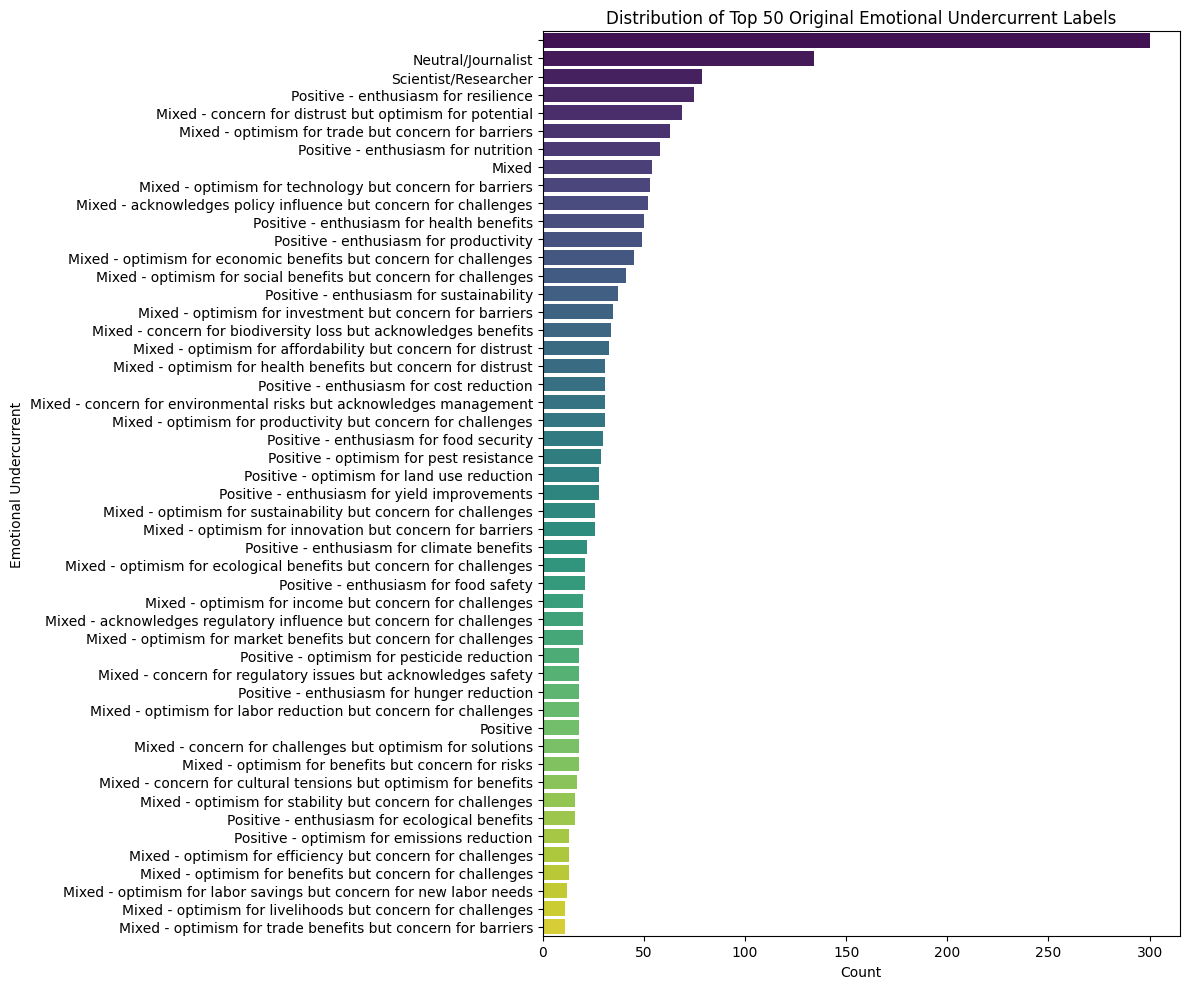

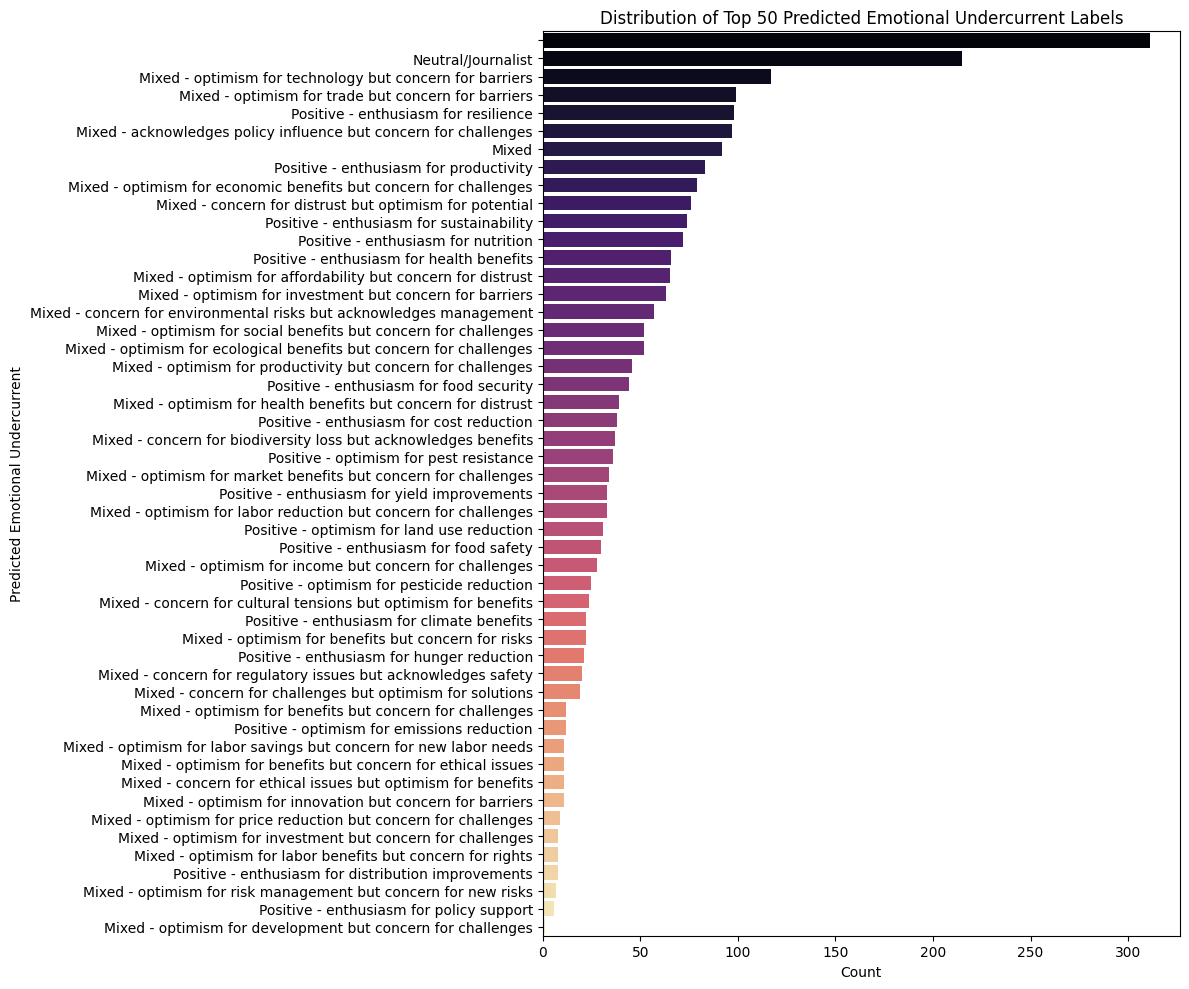

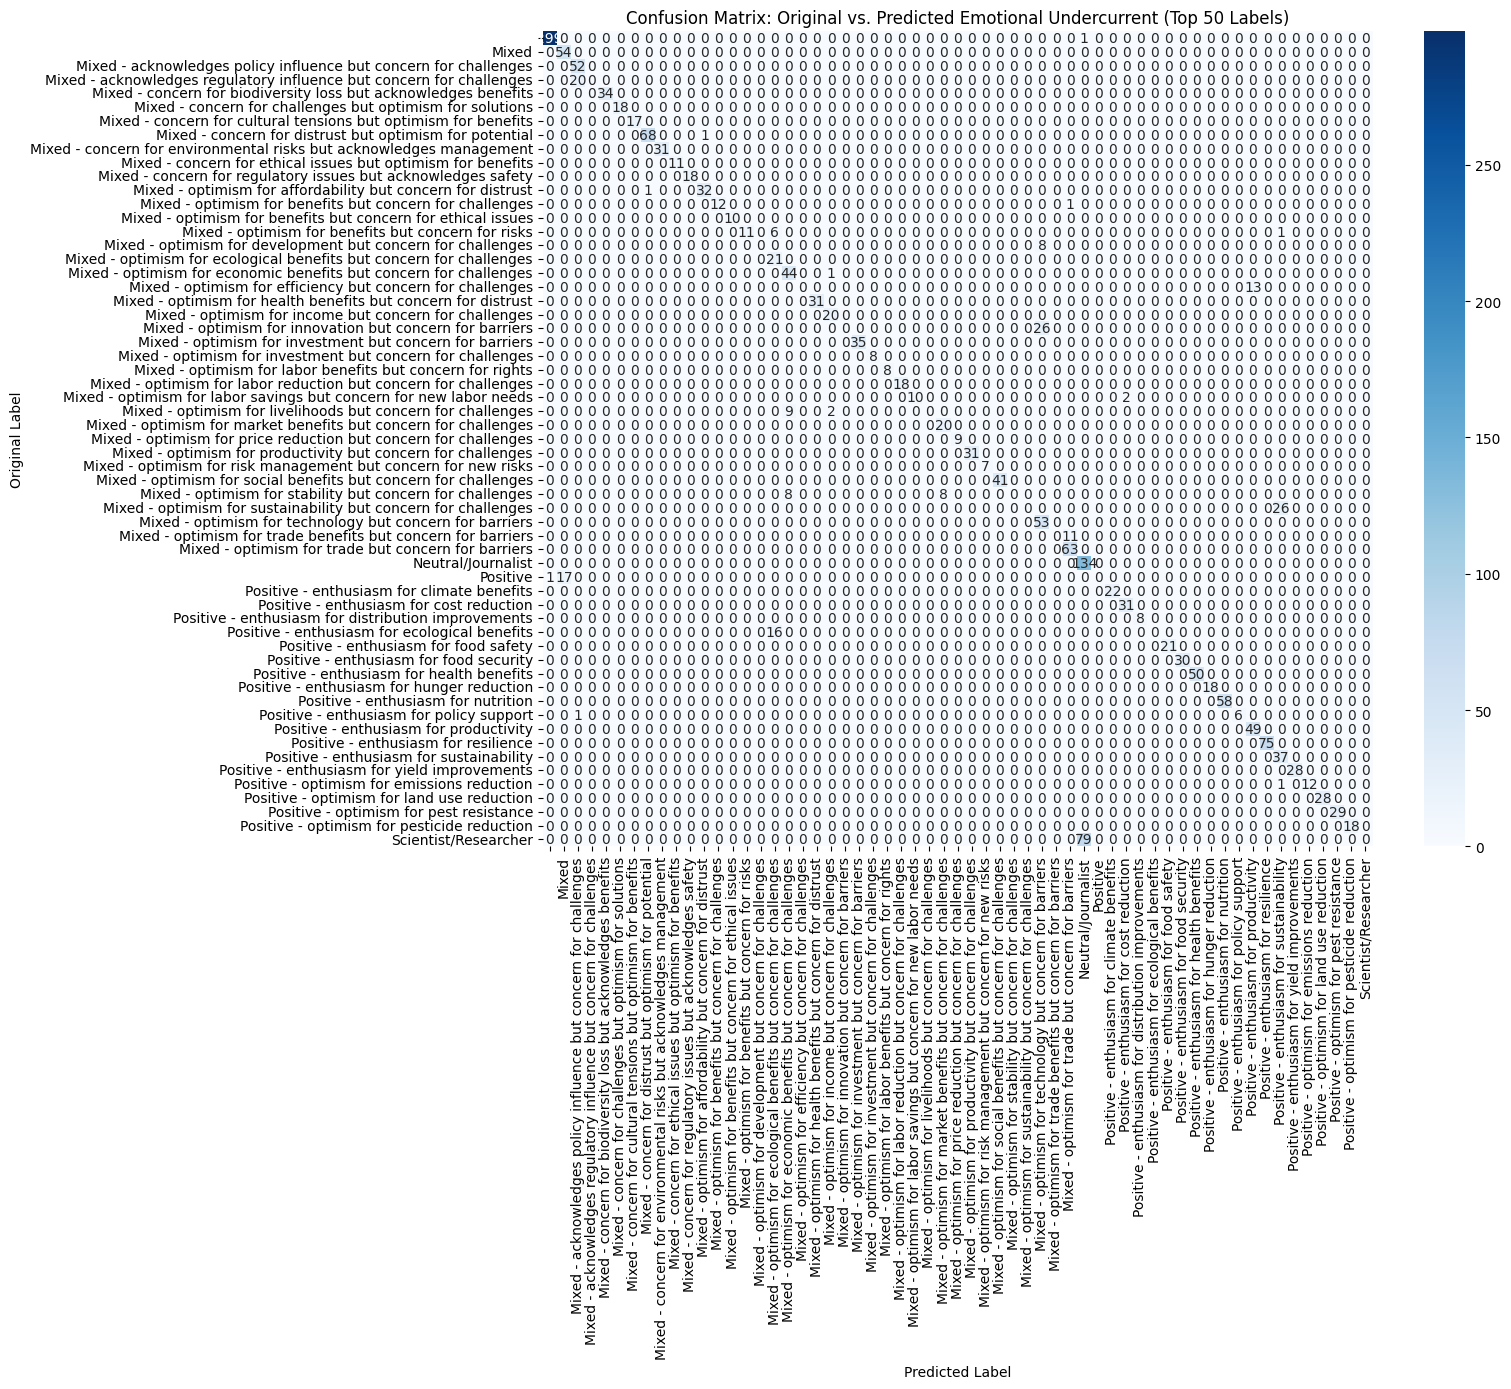

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Create a directory to save visualizations if it doesn't exist
output_dir = "visualizations"
os.makedirs(output_dir, exist_ok=True)

# Get the top 50 most frequent original and predicted labels
top_n = 50
original_label_counts = df['Emotional Undercurrent'].value_counts()
predicted_label_counts = df['Predicted_Emotional_Undercurrent'].value_counts()

top_original_labels = original_label_counts.head(top_n).index.tolist()
top_predicted_labels = predicted_label_counts.head(top_n).index.tolist()

# Combine top labels from both original and predicted to ensure all relevant are included in confusion matrix
all_top_labels = sorted(list(set(top_original_labels + top_predicted_labels)))

# Filter the DataFrame to include only rows with labels in the top N for plotting
df_top_original = df[df['Emotional Undercurrent'].isin(top_original_labels)].copy()
df_top_predicted = df[df['Predicted_Emotional_Undercurrent'].isin(top_predicted_labels)].copy()


# 1. Visualize the distribution of top N original 'Emotional Undercurrent' labels
plt.figure(figsize=(12, 10))
sns.countplot(data=df_top_original, y='Emotional Undercurrent', order=top_original_labels, palette='viridis')
plt.title(f'Distribution of Top {top_n} Original Emotional Undercurrent Labels')
plt.xlabel('Count')
plt.ylabel('Emotional Undercurrent')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'original_sentiment_distribution.png'))
plt.show()

# 2. Visualize the distribution of top N 'Predicted_Emotional_Undercurrent' labels
plt.figure(figsize=(12, 10))
sns.countplot(data=df_top_predicted, y='Predicted_Emotional_Undercurrent', order=top_predicted_labels, palette='magma')
plt.title(f'Distribution of Top {top_n} Predicted Emotional Undercurrent Labels')
plt.xlabel('Count')
plt.ylabel('Predicted Emotional Undercurrent')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'predicted_sentiment_distribution.png'))
plt.show()

# 3. Create a confusion matrix for the top N labels
# Filter the DataFrame to include only rows where BOTH original and predicted labels are in all_top_labels
df_filtered_cm = df[df['Emotional Undercurrent'].isin(all_top_labels) & df['Predicted_Emotional_Undercurrent'].isin(all_top_labels)].copy()


if not df_filtered_cm.empty:
    cm = confusion_matrix(df_filtered_cm['Emotional Undercurrent'], df_filtered_cm['Predicted_Emotional_Undercurrent'], labels=all_top_labels)

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_top_labels, yticklabels=all_top_labels)
    plt.title(f'Confusion Matrix: Original vs. Predicted Emotional Undercurrent (Top {top_n} Labels)')
    plt.xlabel('Predicted Label')
    plt.ylabel('Original Label')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'sentiment_confusion_matrix.png'))
    plt.show()
else:
    print("Filtered DataFrame for confusion matrix is empty. No confusion matrix plot generated.")

## Analyze stakeholder participation

### Subtask:
Analyze the distribution of stakeholder perspectives and create visualizations.


**Reasoning**:
Check for the relevant column, analyze its distribution, and create a bar plot for visualization.



Found stakeholder column: 'source'

Frequency distribution of top 50 filtered stakeholder perspectives:
source
Scientist/Researcher                                                      11
Neutral/Journalist                                                         8
Mixed - optimism for sustainability but concern for challenges             4
Mixed - optimism for efficiency but concern for challenges                 3
Mixed - optimism for stability but concern for challenges                  3
Mixed - acknowledges trade influence but concern for challenges            3
Mixed - optimism for innovation but concern for challenges                 2
Mixed - optimism for competitiveness but concern for challenges            2
Mixed - optimism for environmental benefits but concern for challenges     2
Mixed - optimism for funding but concern for challenges                    2
 USDA                                                                      1
Positive - confidence in safety data      

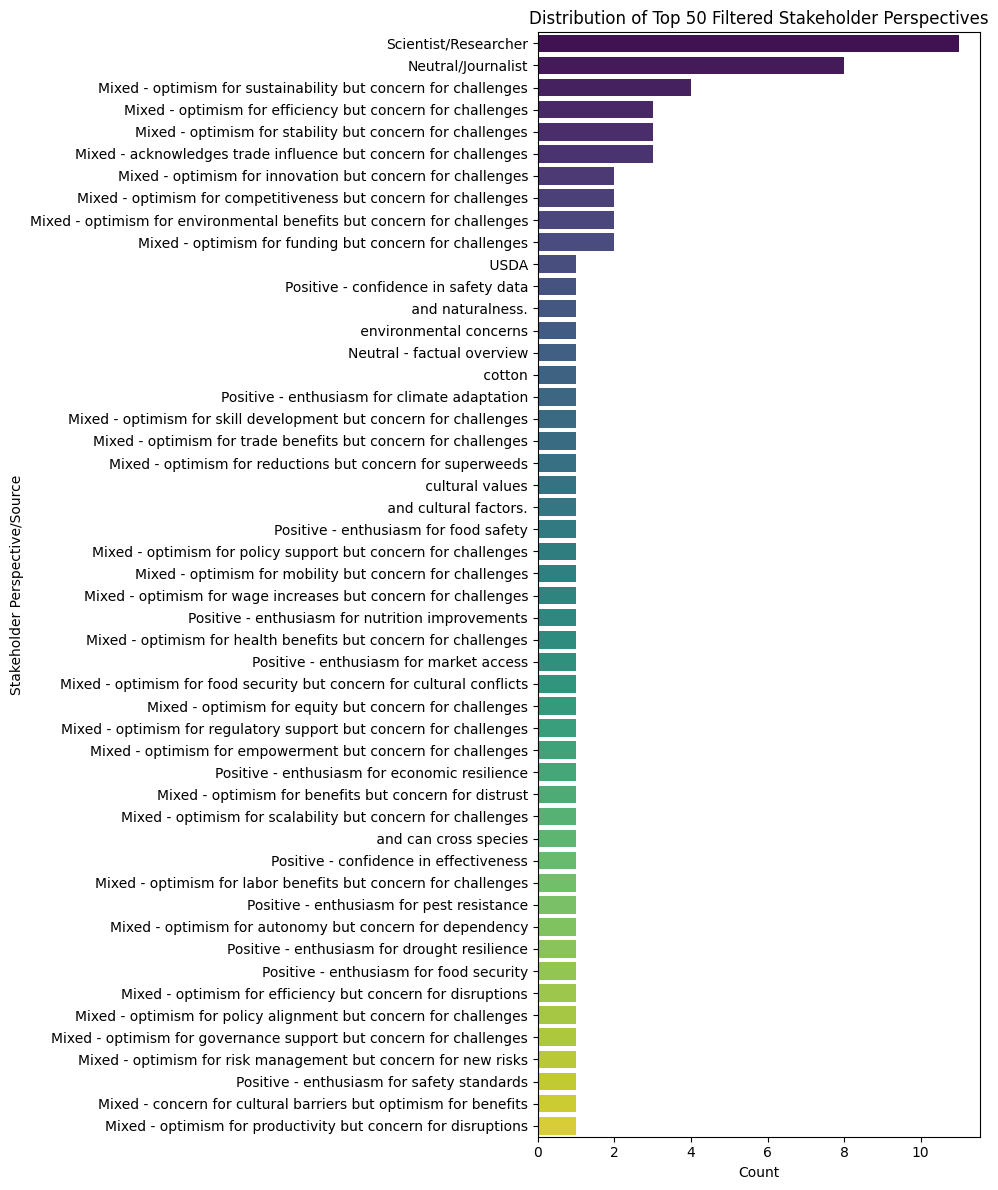

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a directory to save visualizations if it doesn't exist
output_dir = "visualizations"
os.makedirs(output_dir, exist_ok=True)


# Instruction 1: Check for the relevant column
stakeholder_column = None
possible_columns = ['Speaker Perspective/Stakeholder Sentiment', 'source']
for col in possible_columns:
    if col in df.columns:
        stakeholder_column = col
        break

if stakeholder_column is None:
    print("Could not find a relevant column for stakeholder perspective.")
else:
    print(f"Found stakeholder column: '{stakeholder_column}'")

    # Filter out 'Quora', 'Reddit', and entries containing 'GMO' (case-insensitive)
    df_filtered_stakeholders = df[
        (~df[stakeholder_column].str.contains('Quora', case=False, na=False)) &
        (~df[stakeholder_column].str.contains('Reddit', case=False, na=False)) &
        (~df[stakeholder_column].str.contains('GMO', case=False, na=False))
    ].copy()


    # Instruction 2: Analyze the frequency distribution and get top N from the filtered data
    top_n = 50
    stakeholder_counts = df_filtered_stakeholders[stakeholder_column].value_counts()
    top_stakeholders = stakeholder_counts.head(top_n).index.tolist()

    print(f"\nFrequency distribution of top {top_n} filtered stakeholder perspectives:")
    print(stakeholder_counts.head(top_n))

    # Filter the DataFrame to include only rows with top N stakeholders from the filtered data
    df_top_stakeholders_filtered = df_filtered_stakeholders[df_filtered_stakeholders[stakeholder_column].isin(top_stakeholders)].copy()


    # Instruction 3 & 4: Create and display a bar plot for top N filtered stakeholders
    if not df_top_stakeholders_filtered.empty:
        plt.figure(figsize=(10, 12)) # Adjusted figure size for more labels
        sns.countplot(data=df_top_stakeholders_filtered, y=stakeholder_column, order=top_stakeholders, palette='viridis')
        plt.title(f'Distribution of Top {top_n} Filtered Stakeholder Perspectives')
        plt.xlabel('Count')
        plt.ylabel('Stakeholder Perspective/Source')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'stakeholder_distribution_filtered.png'))
        plt.show()
    else:
        print("Filtered DataFrame for stakeholder plot is empty. No plot generated.")

## Perform word frequency analysis

### Subtask:
Analyze word frequencies within key concepts and create visualizations like word clouds.


**Reasoning**:
Concatenate the text data, tokenize, remove stop words, calculate word frequencies, and generate a word cloud.



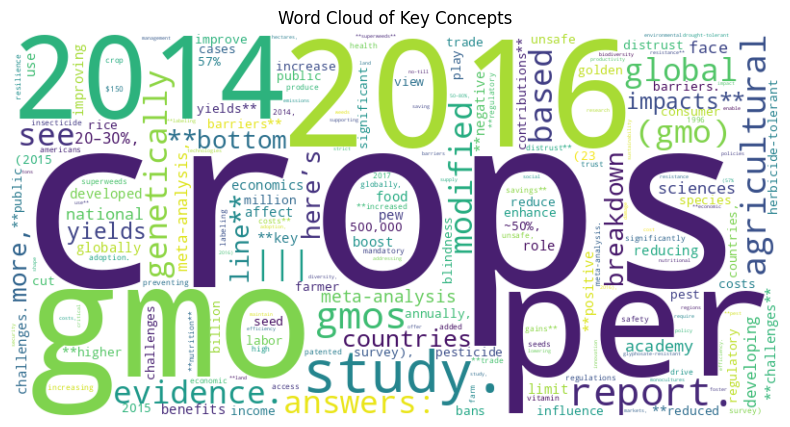

In [ ]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os

# Create a directory to save visualizations if it doesn't exist
output_dir = "visualizations"
os.makedirs(output_dir, exist_ok=True)

# 1. Concatenate all the text data
# Identify the text column (already done in previous steps, using the identified column)
text_column = None
if 'combined_text' in df.columns:
    text_column = 'combined_text'
elif 'text' in df.columns:
    text_column = 'text'
else:
    print("Could not find a suitable text column ('combined_text' or 'text') in the DataFrame.")

if text_column:
    all_text = " ".join(df[text_column].dropna().tolist())

    # 2. Tokenize the combined text (simple split for word cloud)
    words = all_text.split()

    # 3. Remove common English stop words and other irrelevant terms
    # Add potentially irrelevant terms observed in previous steps to the stop words
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(['quora', 'reddit', 'topic', 'selftext', 'title']) # Add observed irrelevant terms

    # Filter out stop words and potentially short words
    filtered_words = [word.lower() for word in words if word.lower() not in custom_stopwords and len(word) > 2]

    # 4. Calculate the frequency of the remaining words
    word_frequencies = Counter(filtered_words)

    # 5. Generate a word cloud visualization
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    # 6. Display and save the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Key Concepts')
    plt.savefig(os.path.join(output_dir, 'word_cloud.png'))
    plt.show()
else:
    print("Word cloud generation skipped as no text column was found.")